# This is a sample Jupyter Notebook

Below is an example of a code cell. 
Put your cursor into the cell and press Shift+Enter to execute it and select the next one, or click 'Run Cell' button.

Press Double Shift to search everywhere for classes, files, tool windows, actions, and settings.

To learn more about Jupyter Notebooks in PyCharm, see [help](https://www.jetbrains.com/help/pycharm/ipython-notebook-support.html).
For an overview of PyCharm, go to Help -> Learn IDE features or refer to [our documentation](https://www.jetbrains.com/help/pycharm/getting-started.html).

In [1]:
import pandas as pd
from pathlib import Path

data_path = Path("data") / "train.xlsx"

price_list = pd.read_excel(
    data_path,
    header=0,
    parse_dates=[0],   # first column → datetime
)

price_list = (
    price_list
    .set_index(price_list.columns[0])
    .rename_axis("date")
)

hour_columns = [
    f"{hour:02d}:00"
    for hour in range(1,len(price_list.columns)+1)
]
price_list.columns = hour_columns

price_list.head()

,01:00,02:00,03:00,04:00,05:00,06:00,07:00,08:00,09:00,10:00,...,15:00,16:00,17:00,18:00,19:00,20:00,21:00,22:00,23:00,24:00
date,,,,,,,,,,,,,,,,,,,,,
2007-01-01,24.31,24.31,21.71,8.42,0.01,0.01,0.02,0.01,0.01,6.31,...,15.00,10.00,8.17,27.77,37.99,33.11,37.99,33.00,36.48,30.65
2007-01-02,16.01,11.00,9.01,7.50,9.00,7.45,16.50,28.01,29.96,39.60,...,37.57,36.45,37.99,53.00,59.69,50.09,50.00,36.22,31.09,29.84
2007-01-03,28.00,24.50,24.15,18.99,15.50,23.11,29.01,39.73,43.81,49.09,...,43.21,43.99,48.00,57.00,60.99,55.51,51.77,34.51,39.31,38.05
2007-01-04,31.01,28.69,27.00,24.20,12.02,27.00,28.00,34.85,41.31,42.03,...,40.01,38.00,42.66,53.00,58.99,53.50,44.01,35.00,34.46,31.57
2007-01-05,22.00,19.50,17.55,15.91,11.40,22.65,27.30,34.00,40.01,45.00,...,40.06,38.00,38.61,49.84,53.00,45.91,36.74,29.61,30.61,27.51


In [2]:
import numpy as np

all_prices = price_list.to_numpy().ravel()
buy_threshold = np.quantile(all_prices, 1/3)
sell_threshold = np.quantile(all_prices, 2/3)

buy_threshold, sell_threshold

(np.float64(34.0), np.float64(56.05))

In [3]:
# environment
from dataclasses import dataclass
from typing import Tuple

@dataclass
class DamConfig:
    prices: np.ndarray   # 1-D array of prices per time step
    Wmax: float = 100000.00 # max reservoir capacity (m³)
    Vmax: float = 18000.00  # max water volume that can move each step (m³)
    W_init: float  = 50000.00 # starting water (m³)
    g: float = 9.81      # gravity (m/s²) for potential energy
    rho: float = 1000.0  # water density (kg/m³)
    h: float = 30.0             # difference in height (m)
    eta_turbine: float = 0.9    # sell efficiency
    eta_pump: float = 0.8       # buy efficiency

class DamEnvironment:
    ACTIONS = {0: "idle", 1: "sell", 2: "buy"}

    def __init__(self, config: DamConfig):
        self.cfg = config
        self.reset()

    def reset(self) -> Tuple[float, float]:
        self.t = 0
        self.W_t = self.cfg.W_init
        self.pnl = 0.0 # profit and loss, operational efficiency
        return self._observation()

    def _observation(self) -> Tuple[float, float]:
        water_ratio = self.W_t / self.cfg.Wmax
        price_t = self.cfg.prices[self.t]
        return water_ratio, price_t

    def _potential_energy_mwh(self, volume_m3: float) -> float:
        joules = self.cfg.rho * self.cfg.g * self.cfg.h * volume_m3
        mwh = joules / 3.6e9
        return mwh

    def step(self, action: int):
        if action not in self.ACTIONS:
            raise ValueError(f"Unknown action {action}")

        price = self.cfg.prices[self.t]

        if action == 1:  # sell max
            V = min(self.cfg.Vmax, self.W_t) #make sure we don't sell more than we have'
        elif action == 2:  # buy max
            V = min(self.cfg.Vmax, self.cfg.Wmax - self.W_t)
        else:
            V = 0.0

        E_pot = self._potential_energy_mwh(V)

        if action == 1:
            reward = price * (self.cfg.eta_turbine * E_pot)
            self.pnl += reward
            self.W_t -= V
        elif action == 2:
            reward = -price * (E_pot / self.cfg.eta_pump)
            self.pnl += reward
            self.W_t += V
        else:
            reward = 0.0

        self.t += 1
        done = self.t >= len(self.cfg.prices)

        obs = self._observation() if not done else (None, None)
        info = {"volume_m3": V, "energy_mwh": E_pot}
        return obs, reward, done, info

In [4]:
data_path = Path("data") / "validate.xlsx"

price_list = pd.read_excel(
    data_path,
    header=0,
    parse_dates=[0],   # first column → datetime
)

price_list = (
    price_list
    .set_index(price_list.columns[0])
    .rename_axis("date")
)

hour_columns = [
    f"{hour:02d}:00"
    for hour in range(1,len(price_list.columns)+1)
]
price_list.columns = hour_columns
validation_prices = price_list.to_numpy().ravel()

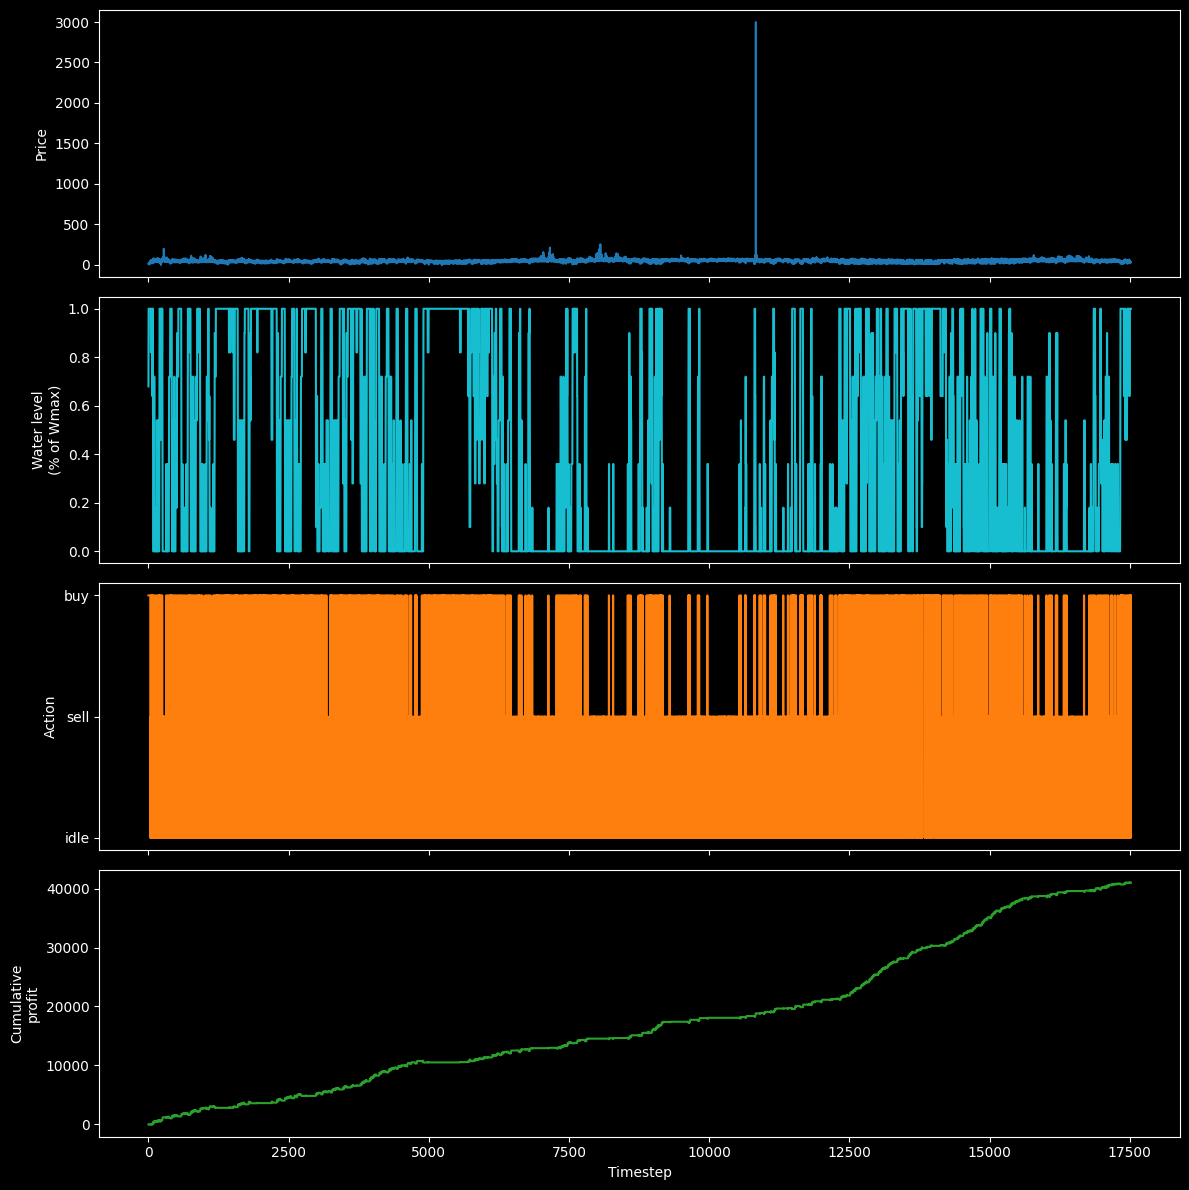

In [5]:
import matplotlib.pyplot as plt

# Rebuild environment on validation data
val_config = DamConfig(
    prices=validation_prices,
)
val_env = DamEnvironment(val_config)

# Threshold policy rollout
obs = val_env.reset()
records = {
    "price": [],
    "water": [],
    "action": [],
    "reward": [],
    "pnl": [],
}

done = False

def policy(price):
    if price < buy_threshold:
        return 2
    if price > sell_threshold:
        return 1
    return 0

while not done:
    _, price_t = obs
    act = policy(price_t)
    obs, reward, done, info = val_env.step(act)

    records["price"].append(price_t)
    records["water"].append(val_env.W_t)
    records["action"].append(act)
    records["reward"].append(reward)
    records["pnl"].append(val_env.pnl)

# Visualization
timesteps = np.arange(len(records["price"]))

fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axes[0].plot(timesteps, records["price"], color="tab:blue")
axes[0].set_ylabel("Price")

axes[1].plot(timesteps, np.array(records["water"]) / val_config.Wmax, color="tab:cyan")
axes[1].set_ylabel("Water level\n(% of Wmax)")

axes[2].step(timesteps, records["action"], where="mid", color="tab:orange")
axes[2].set_yticks([0, 1, 2])
axes[2].set_yticklabels(["idle", "sell", "buy"])
axes[2].set_ylabel("Action")

axes[3].plot(timesteps, records["pnl"], color="tab:green")
axes[3].set_ylabel("Cumulative\nprofit")
axes[3].set_xlabel("Timestep")

fig.tight_layout()
plt.show()